In [1]:
import sys

sys.path.insert(0, '/mnt/data/molchanov/dltranz')

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

from domyshnik.models import *
from domyshnik.data import *
from domyshnik.constants import *
from domyshnik.utils import *

def draw(imgs):
        if isinstance(imgs, list):
            imgs = torch.stack(imgs)
        fig = plt.figure()
        rows, columns = 1, imgs.shape[0]
        for i in range(imgs.shape[0]):
            fig.add_subplot(rows, columns, i+1)
            if imgs[i].size(0) == 3:
                plt.imshow(imgs[i].transpose(0, 1).transpose(1, 2))
            else:
                plt.imshow(imgs[i])
        plt.show()
        
%matplotlib inline


model _params:
        CURRENT_PARAMS domyshnik
        N_AUGMENTS 20
        LEARNING_RATE 0.0004
        GAMMA 0.9025
        BATCH_SIZE 128
        EPOCHS 30
        SAMPLING_STRATEGY HardNegativePair
        NEGATIVES_COUNT 10
        MARGING 0.1
        STEP_SIZE 5
        MODEL_POSTFIX mnist
        ADD_INFO {'refresh_reward_step': 4}
       


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 4, 3, 32, 32]) torch.Size([4, 3, 32, 32])


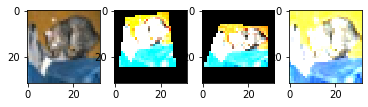

In [2]:
loader = get_cifar10_test_loader(BATCH_SIZE, n_augments=3)
sample = next(iter(loader))[0]
print(sample.size(), sample[0].size())
draw(sample[0])

In [3]:
inp = F.soft_max(torch.randn(5, 3))
F.kl_div(input=torch.Tensor([0.5, 0.5]), 
         target=torch.Tensor([0.5, 0.5]))

tensor(-0.5966)

In [43]:
inp = F.log_softmax(torch.randn(5, 3), dim=-1)
trg = F.log_softmax(torch.randn(5, 3), dim=-1)
print(F.softmax(inp, dim=-1))
#print()
print(F.softmax(trg, dim=-1))
trg = F.softmax(trg, dim=-1)

tensor([[0.4659, 0.2324, 0.3017],
        [0.0379, 0.0835, 0.8785],
        [0.3435, 0.6353, 0.0212],
        [0.0564, 0.6376, 0.3060],
        [0.7161, 0.1611, 0.1228]])
tensor([[0.0272, 0.2313, 0.7415],
        [0.4222, 0.3608, 0.2169],
        [0.7198, 0.1370, 0.1431],
        [0.6095, 0.3082, 0.0823],
        [0.8608, 0.0913, 0.0479]])


In [35]:
F.kl_div(inp, trg, reduction='none').sum(-1)

tensor([0.1596, 0.6725, 0.5518, 0.0873, 0.9967])

In [ ]:
a = inp


In [34]:
torch.pairwise_distance(inp,trg)

tensor([2.8476, 3.2002, 3.2514, 3.2022, 3.4977])

In [41]:
dist1 = F.log_softmax(torch.Tensor([0.5, 0.5]))
dist2 = torch.Tensor([0.5, 0.5])

/mnt/data/molchanov/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [42]:
F.kl_div(dist1, dist2, reduction='none').sum(-1)

tensor(0.)

In [30]:
labels = torch.Tensor([0,0,0, 1,1,1,2,2,2])
n = labels.size(0)

In [33]:
x = labels.expand(n,n) - labels.expand(n,n).t()     
print(x)
            
# positive pairs
positive_pairs = torch.triu((x == 0).int(), diagonal = 1).nonzero()
print(positive_pairs)

tensor([[ 0.,  0.,  0.,  1.,  1.,  1.,  2.,  2.,  2.],
        [ 0.,  0.,  0.,  1.,  1.,  1.,  2.,  2.,  2.],
        [ 0.,  0.,  0.,  1.,  1.,  1.,  2.,  2.,  2.],
        [-1., -1., -1.,  0.,  0.,  0.,  1.,  1.,  1.],
        [-1., -1., -1.,  0.,  0.,  0.,  1.,  1.,  1.],
        [-1., -1., -1.,  0.,  0.,  0.,  1.,  1.,  1.],
        [-2., -2., -2., -1., -1., -1.,  0.,  0.,  0.],
        [-2., -2., -2., -1., -1., -1.,  0.,  0.,  0.],
        [-2., -2., -2., -1., -1., -1.,  0.,  0.,  0.]])
tensor([[0, 1],
        [0, 2],
        [1, 2],
        [3, 4],
        [3, 5],
        [4, 5],
        [6, 7],
        [6, 8],
        [7, 8]])


In [31]:
labels.expand(n,n)

tensor([[0., 0., 0., 1., 1., 1., 2., 2., 2.],
        [0., 0., 0., 1., 1., 1., 2., 2., 2.],
        [0., 0., 0., 1., 1., 1., 2., 2., 2.],
        [0., 0., 0., 1., 1., 1., 2., 2., 2.],
        [0., 0., 0., 1., 1., 1., 2., 2., 2.],
        [0., 0., 0., 1., 1., 1., 2., 2., 2.],
        [0., 0., 0., 1., 1., 1., 2., 2., 2.],
        [0., 0., 0., 1., 1., 1., 2., 2., 2.],
        [0., 0., 0., 1., 1., 1., 2., 2., 2.]])